### Paso 1: Planteamiento del problema y recopilación de datos

In [3]:
###################################
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import numpy as np
import json
current_dir = os.getcwd()
url = os.path.join(current_dir, "../data/raw/AB_NYC_2019.csv")
data = pd.read_csv(url)
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
# DEFINIR EL PROBLEMA: POR DEFECTO [LISTAS VACÍAS]
target = "price"    # el target u objetivo del modelo
categorical_variable = ["neighbourhood_group","neighbourhood", "room_type"]    # Variables categóricas
drop_columns = ["id", "host_id", "name","host_name", "latitude", "longitude","last_review"] # columnas para hacer drop por falta de relevancia
factors_associated_target = ["availability_365"]   # factores asociados al target. Relación del target con las predictoras. Subjetivo.


### Paso 2: Exploración y limpieza de datos

In [5]:
# Obtener las dimensiones
data.shape

(48895, 16)

In [6]:
# Obtener información sobre tipos de datos y valores no nulos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [7]:
nan = data.isna().sum()
nan

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

- Existen un total de 48895 filas (en este caso, reservas de airbnb) y 15 columnas, de entre las que encontramos el objetivo o clase a predecir, `price`.
- La variable `las_review` y `reviews_per_month` tiene 38843 instancias con valores, por lo que contendría más de 10000 valores nulos. El resto de variables cuentan siempre con valor.
- Los datos cuentan con 10 características numéricas y 3 características categóricas ("neighbourhood_group","neighbourhood", "room_type").

#### Eliminar duplicados
Se decide eliminar `drop_columns`, ya que se observa son poco o nada relevantes para el precio.

In [8]:
drop_columns

['id', 'host_id', 'name', 'host_name', 'latitude', 'longitude', 'last_review']

In [9]:
nan_percentage = data.isna().mean()*100
# Identificar las columnas con más del 90% de NaN y eliminarlas directamente
columns_to_drop = nan[nan_percentage > 90].index
print(columns_to_drop)
# Eliminar las columnas
data_cleaned = data.drop(columns=columns_to_drop, axis=1)

data

Index([], dtype='object')


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2


In [10]:
duplicated_row = data.duplicated().sum()
duplicated_row

np.int64(0)

In [11]:

if(duplicated_row==0):
    print("No hay duplicados")
else:
    print("Si hay duplicados, se procede a eliminarlos")

No hay duplicados


En este caso, no encontramos ningún valor duplicado.

In [12]:
# data = data.drop_duplicates(subset = data.columns.difference(["id"]))
# data.shape

In [13]:
# ELIMINAR DUPLICADOS, ESPECIFICAR CON .difference(["id"] SI ES NECESARIO
data = data.drop_duplicates(subset = data.columns)
print(data.shape)
data.head()

(48895, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


Se procede a eliminar las columnas que hayamos definido en `drop_columns` cuando hemos definido el problema.

In [14]:
if(drop_columns):   # si drop_columns tiene valores y no está vacío entra
    data = data.drop(drop_columns, axis = 1)
data

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,Private room,150,3,0,NaN,1,365
3,Brooklyn,Clinton Hill,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,Entire home/apt,80,10,9,0.10,1,0
...,...,...,...,...,...,...,...,...,...
48890,Brooklyn,Bedford-Stuyvesant,Private room,70,2,0,NaN,2,9
48891,Brooklyn,Bushwick,Private room,40,4,0,NaN,2,36
48892,Manhattan,Harlem,Entire home/apt,115,10,0,NaN,1,27
48893,Manhattan,Hell's Kitchen,Shared room,55,1,0,NaN,6,2


In [15]:
data.describe()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


### Paso 3: Análisis de variables univariante

#### Análisis sobre variables categóricas

In [16]:
categorical_variable

['neighbourhood_group', 'neighbourhood', 'room_type']

Variables categóricas
Una **variable categórica** es un tipo de variable que puede tomar uno de un número limitado de categorías o grupos. Estos grupos son a menudo nominales (por ejemplo, el color de un coche: rojo, azul, negro, etc, pero ninguno de estos colores es inherentemente "mayor" o "mejor" que los demás) pero pueden también representarse mediante números finitos.

Para representar este tipo de variables utilizaremos histogramas. Antes de comenzar a graficar, debemos identificar cuáles son categóricas, y se puede comprobar fácilmente analizando el rango de valores. En este caso, las variables categóricas son `neighbourhood_group`,`neighbourhood` y `room_type`.

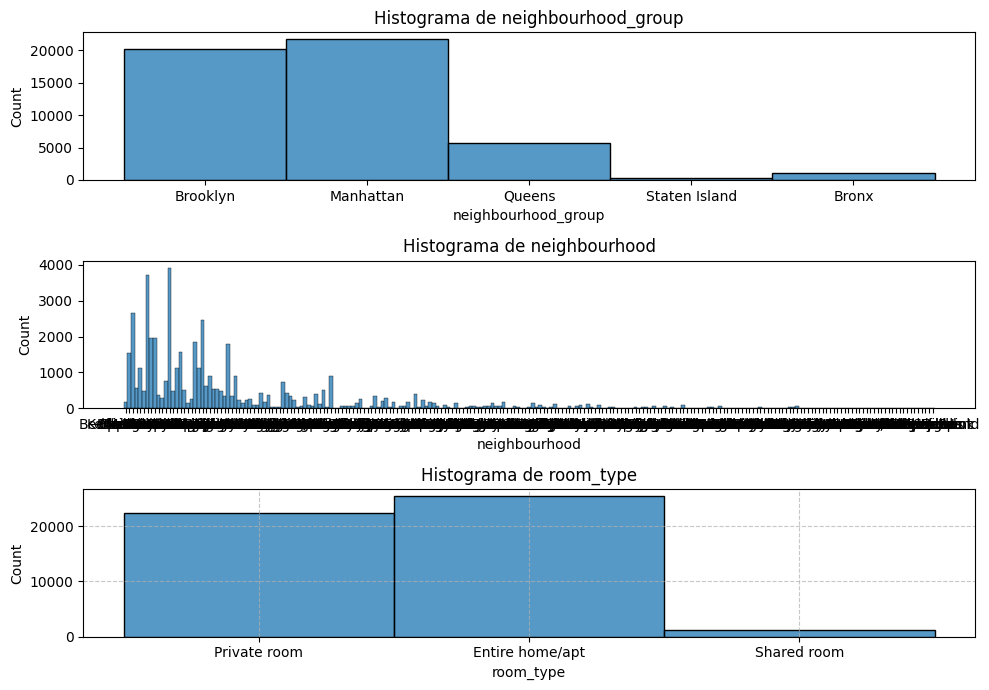

In [17]:
if(categorical_variable):
    fig, axis = plt.subplots(len(categorical_variable), 1,figsize = (10, 7))

    if len(categorical_variable) == 1:
        axis = [axis]   # convertir en lista para que no me salga error

    for i,col in enumerate(categorical_variable):
        # Crear un histograma múltiple
        sns.histplot( data = data, ax=axis[i], x = col)
        axis[i].set_title(f'Histograma de {col}')
        # grid
        plt.grid(linestyle="--", alpha=0.7)
        # Ajustar el layout
        plt.tight_layout()

    # Mostrar el plot
    plt.show()
else:
    print("categorical_variable está vacío, debe llenarse para poder representarse")

- neighbourhood_group: Se observa que más de 40.000 reservas se producen en Brooklyn y Manhattan (más de 20K cada uno).
- room_type: Se observa que gran parte de las reservas se hace en habitaciones privadas o apartamentos enteros.
- neighbourhood: Se observa que algunos vecindarios superan 500 reservas. El resto de reservas tiene unos valores relativamente uniformes.

#### Análisis sobre variables numéricas

Antes de comenzar a graficar, debemos identificar cuáles son las numéricas, que son `price`, `minimum_nights` y `number_of_reviews`, `reviews_per_month`,`calculated_host_listings_count`, `availability_365`. Se procede a graficar de forma automática:

In [18]:
data.select_dtypes(include='number').columns

Index(['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

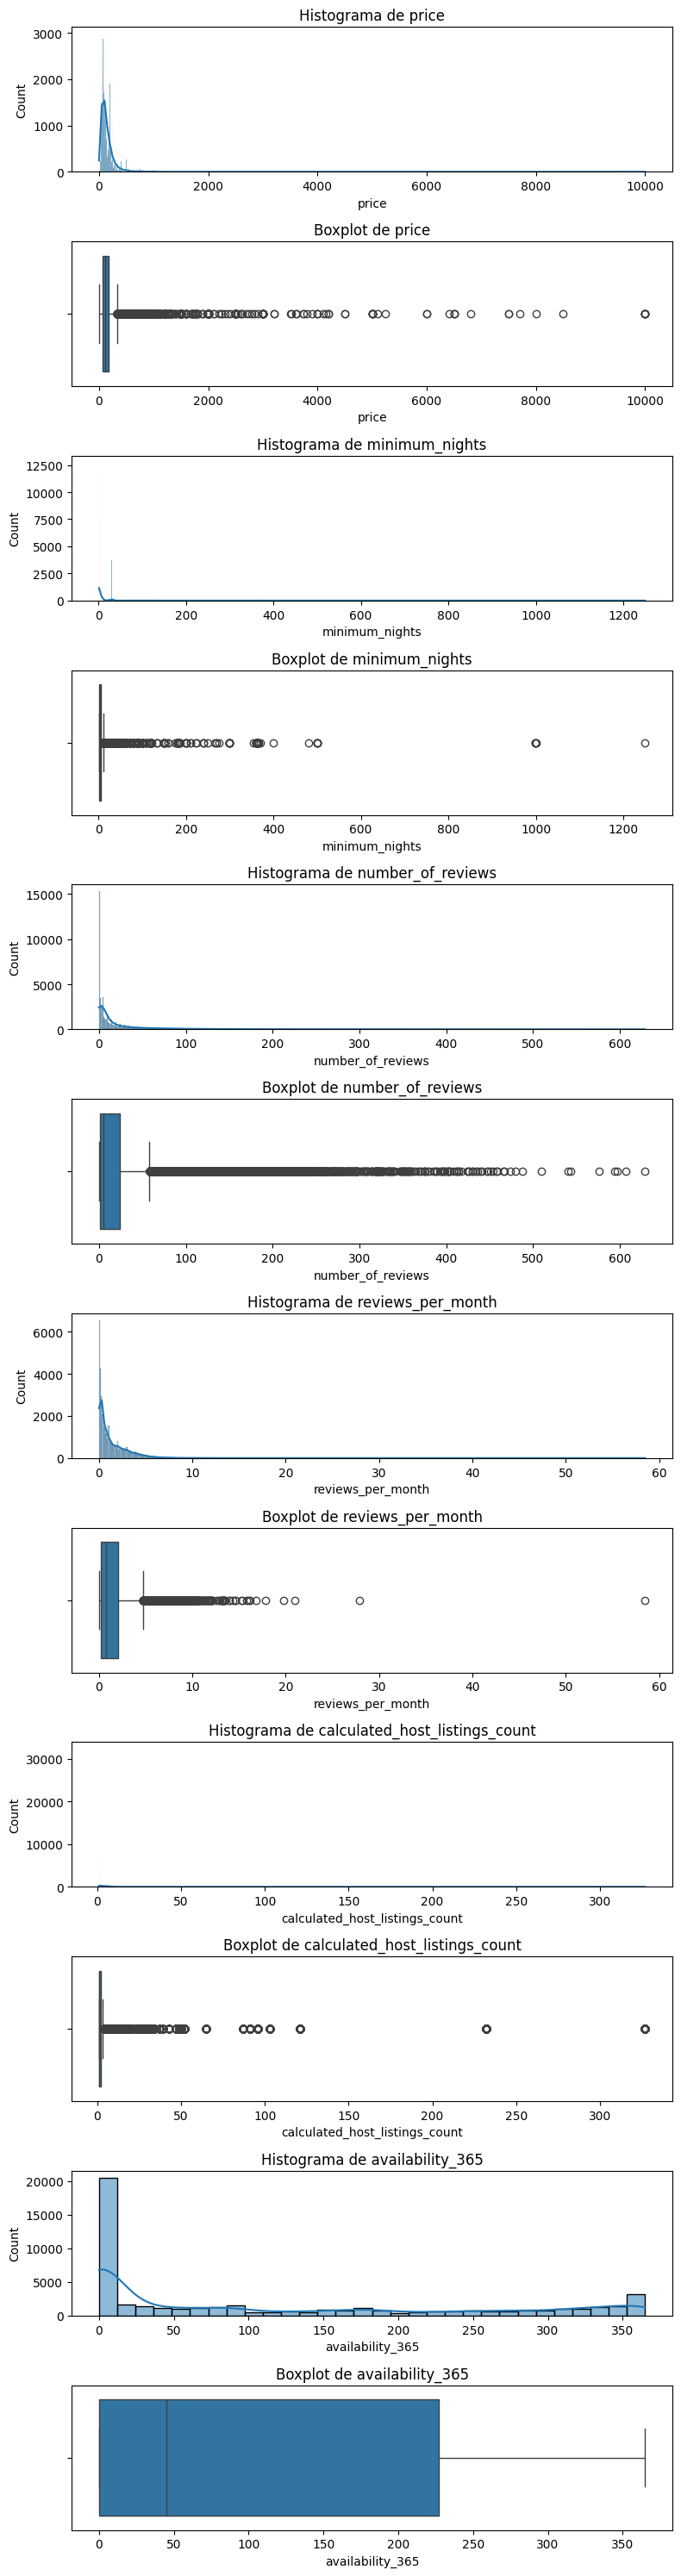

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
# SOLO MODIFICAR COLUMNAS QUE SE QUIERAN EXCLUIR DE LAS NUMERICAS [ NO HACER CASO: Eran los IDs y ya se han eliminado]
column_filter= data.select_dtypes(include='number').drop(columns=[''], errors='ignore').columns
# Crear la figura con 2 columnas y una fila por variable
fig, axes = plt.subplots(len(column_filter)*2, 1, figsize=(8, len(column_filter) * 5))

# Iterar sobre cada columna del DataFrame
for i, col in enumerate(column_filter):
    idx=i*2
    # Histograma en la primera fila
    sns.histplot(data=data, x=col, kde=True, ax=axes[idx])
    axes[idx].set_title(f'Histograma de {col}')
    

    # Boxplot en la segunda fila
    sns.boxplot(data=data, x=col, ax=axes[idx+1])
    axes[idx+1].set_title(f'Boxplot de {col}')
    

# Ajustar diseño
plt.tight_layout()
plt.show()

- price: La mayoria de los precios se encuentran entre 0-500$.
- minimum_nights: Los outliers y la concentración de los datos en los primeros valores impiden extraer mucho más.
- number_of_reviews: Tiene valores atípicos que están lejos de la distribución estándar y su distribución es ligeramente asimétricas pero cercana a una distribución normal totalmente sesgada hacia la izquierda, donde la moda es inferior a la media.
- reviews_per_month: Tiene valores atípicos que están lejos de la distribución estándar y su distribución es ligeramente asimétricas pero cercana a una distribución normal totalmente sesgada hacia la izquierda, donde la moda es inferior a la media.
- calculated_host_listings_count: Tiene valores atípicos que están lejos de la distribución estándar y su distribución es ligeramente asimétricas pero cercana a una distribución normal totalmente sesgada hacia la izquierda, donde la moda es inferior a la media.
- availability_365: aproximadamente el 35% de los valores toman el valor 0. Se puede considerar un outlier. El resto de datos se encuentran de forma uniforme.

La combinación de los dos gráficos anteriores por cada variable nos permite conocer la distribución y sus características estadísticas. De la visualización resultante podemos ver que ambas variables tienen valores atípicos que están lejos de la distribución estándar y que sus distribuciones son ligeramente asimétricas pero cercanas a una distribución normal; todas totalmente sesgadas hacia la izquierda.

### Paso 4: Análisis de variables multivariante

Tras analizar las características una a una, es momento de analizarlas en relación con la predictora y con ellas mismas, para sacar conclusiones más claras acerca de sus relaciones y poder tomar decisiones sobre su procesamiento.

Así, si quisiéramos eliminar una variable debido a una alta cantidad de valores nulos o ciertos outliers, es necesario antes aplicar este proceso para asegurar que la eliminación de ciertos valores no son críticos para averiguar el precio de un alquiler. Por ejemplo, la variable `reviews_per_month` tiene muchos valores nulos, y tendríamos que asegurar que no hay relación entre ella y el precio antes de eliminarla, ya que quizá pudiera ser muy significativa e importante para el modelo y su presencia podría decantar la predicción.

#### Análisis numérico-numérico

Para comparar dos columnas numéricas se utilizan diagramas de dispersión y análisis de correlaciones.
##### Price - ('price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month','calculated_host_listings_count', 'availability_365')

In [20]:
data.select_dtypes(include='number').columns

Index(['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

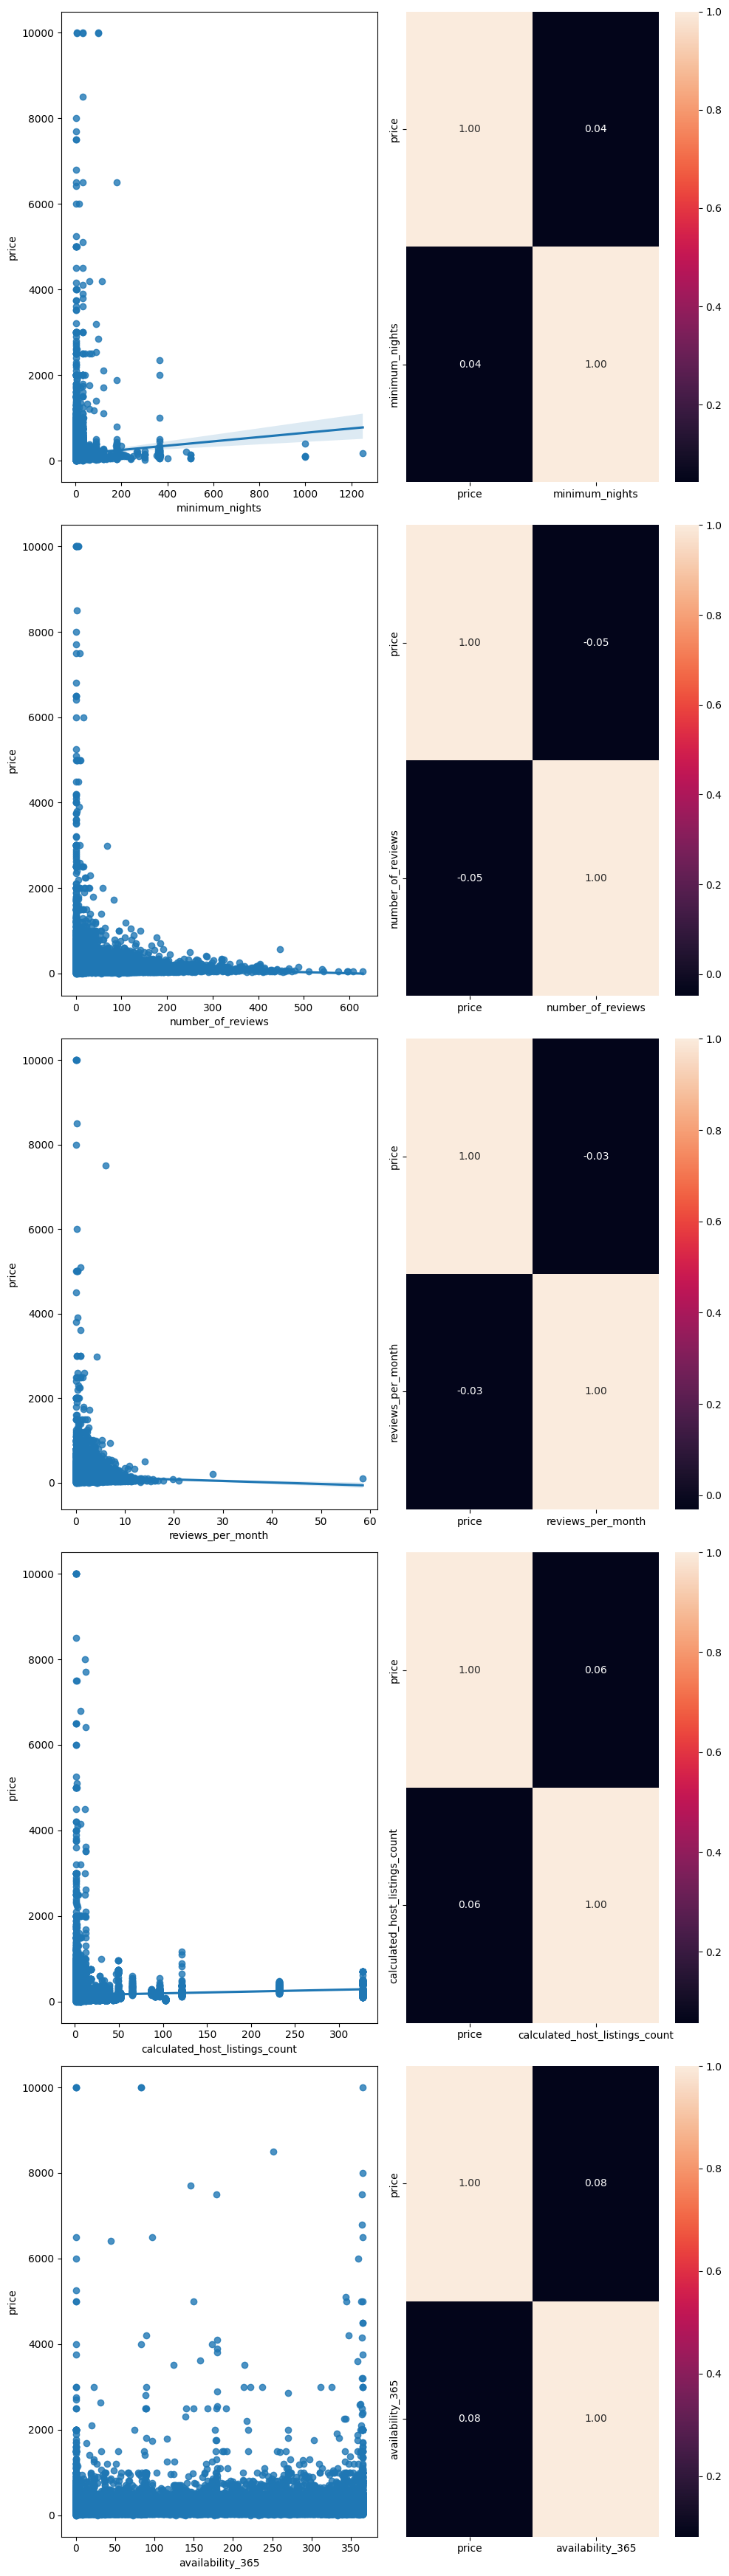

In [21]:
# Automatizado para solo filtrar los numericos a numericos y excluir que se compare el objetivo o clase a predecir, es decir, price consigo mismo
if(target):
    column_filter= data.select_dtypes(include='number').drop(columns=[target], errors='ignore').columns
    fig, axis = plt.subplots(len(column_filter), 2, figsize = (10, 7*(len(column_filter))))

    # Crear un diagrama de dispersión múltiple y la matriz de correlación entre las dos variables (predictora-target)
    for i,col in enumerate(column_filter):
        sns.regplot(ax = axis[i, 0], data = data, x = col, y = target)
        sns.heatmap(data[[target, col]].corr(), annot = True, fmt = ".2f", ax = axis[i,1], cbar = True)

    # Ajustar el layout
    plt.tight_layout()

    # Mostrar el plot
    plt.show()
else:
    print(f"target {target} está vacío, se debe especificar el target para poder representar.")

No se observa que el precio tenga una correlación con ninguna variable, pero se considera que es debido a la cantidad en los outliers (se podría ver si eliminandolos mejora la correlación). Puede tratarse también de que el precio del alquiler sea factor de diversas variables y no de una en concreta.

En resumen, no existe relación con estas características frente a la predictora, la significancia no es muy elevada, no siendo factores decisivos sobre el precio de un alquiler. 

#### Análisis categórico-categórico [NO HAY QUE HACERLO POR TRATARSE EL TARGET DE UNA VARIABLE NUMÉRICA]

In [22]:
if(target):
    if (target not in categorical_variable):
        print(f"No es necesario hacer el análisis categórico-categórico porque el target objetivo '{target}' del modelo es una variable numérica.")
    else:
        n_rows = (len(categorical_variable)+2) // 3
        n_cols = 3
        fig, axis = plt.subplots(n_rows, n_cols, figsize = (15, 7))

        # Crear un histograma de cada variable categórica predictora con la variable target categórica
        for i,col in enumerate(categorical_variable):
            idx = i%2
            j = i%3
            sns.countplot(ax=axis[idx,j], data = data, x = col, hue = target)
        # Eliminar subgráficos vacíos (si los hay)
        for i in range(len(categorical_variable), n_rows*n_cols):
            idx = i // n_cols  # Fila vacía
            j = i % n_cols   # Columna vacía
            fig.delaxes(axis[idx][j])
        # Ajustar el layout
        plt.tight_layout()

        # Mostrar el plot
        plt.show()

else:
    print(f"target {target} está vacío, se debe especificar el target para poder representar.")


No es necesario hacer el análisis categórico-categórico porque el target objetivo 'price' del modelo es una variable numérica.


In [23]:
data.columns

Index(['neighbourhood_group', 'neighbourhood', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

##### Combinaciones de la clase con varias predictoras

In [24]:
# DESACTIVAR CUANDO YA LO TIENES DEFINIDO
# factors_associated_target = input("Introduce todas las variables predictoras separados por comas que consideres que pueden estar relacionadas con el target")
# factors_associated_target = [x.strip() for x in factors_associated_target.split(",")]

In [25]:
categorical_variable

['neighbourhood_group', 'neighbourhood', 'room_type']

In [26]:
factors_associated_target

['availability_365']

In [27]:
# fig, axis = plt.subplots(figsize = (5, 10), nrows = 3)

# sns.barplot(ax = axis[0], data = data, x = "neighbourhood_group", y = target, hue = "availability_365")
# sns.barplot(ax = axis[1], data = data, x = "neighbourhood", y = target, hue = "availability_365")
# sns.barplot(ax = axis[2], data = data, x = "room_type", y = target, hue = "availability_365")

# plt.tight_layout()

# plt.show()

tiempo:-0.025418996810913086


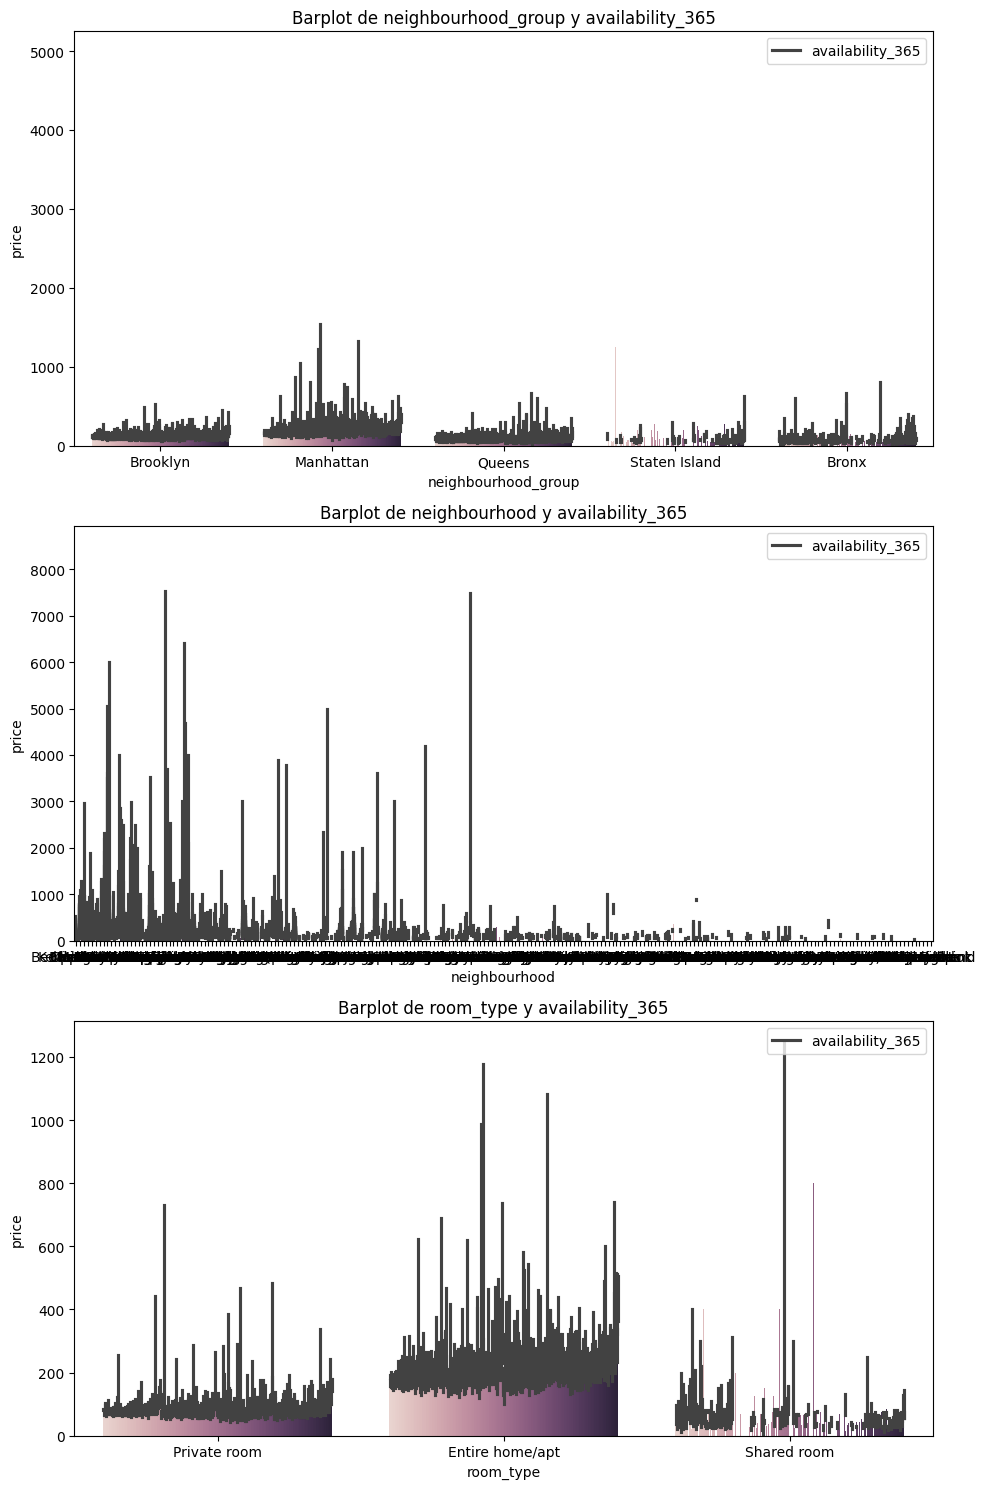

In [28]:
# GENERO LAS GRÁFICAS DEL TARGET CON VARIAS PREDICTORAS Y CON AQUELLA QUE SE CONSIDERA SUBJETIVAMENTE QUE PUEDE SER INTERESANTE
import time
if(categorical_variable):
    start_time = time.time()
    # Generar combinaciones de gráficos entre las variables categóricas y los factores asociados al target
    combinations = list(itertools.product(categorical_variable, factors_associated_target))

    # Separar las combinaciones en impares y pares
    # combinations_odd = combinations[::2]  # Combinaciones pares
    # combinations_even = combinations[1::2]  # Combinaciones impares

    # Crear la figura con suficiente espacio para los subgráficos (evitar llamar a plt.subplots repetidamente)
    fig, axis = plt.subplots(len(combinations), 1, figsize=(10, 15))

    # Asegurarse de que 'axis' sea un arreglo 1D
    axis = axis.flatten() if isinstance(axis, np.ndarray) and axis.ndim > 1 else axis

    end_time = time.time()
    # Graficar todas las combinaciones en un solo bucle (sin dividir en pares e impares)
    for i, (col, factor) in enumerate(combinations):
        sns.barplot(ax=axis[i], data=data, x=col, y=target, hue=factor)
        axis[i].set_title(f'Barplot de {col} y {factor}')
        axis[i].legend(loc="upper right", labels=[factor])
    print(f"tiempo:{start_time - end_time}")
    plt.tight_layout()
    plt.show()

else:
    print("categorical_variable está vacío, debe llenarse para poder representarse")

Del primer gráfico, se observa que Manhattan tiene los precios más altos y más dispersos, mientras que Staten Island y Bronx tienen precios más bajos en general. Por otro lado, del segundo gráfico, los apartamentos enteros tienen precios más altos y con mayor variabilidad; las habitaciones privadas y compartidas son más baratas en comparación. Se observa en ambas gráficas que hay mucha disponibilidad de alquileres.

##### Análisis de correlaciones

In [29]:
import json
categorical_variable_list = []
for cat in categorical_variable:

  data[f"{cat}_n"] = pd.factorize(data[cat])[0]
  categorical_variable_list.append(f"{cat}_n")
  transformation_rules = {row[cat]: row[f"{cat}_n"] for _, row in data[[cat, f"{cat}_n"]].drop_duplicates().iterrows()}

  with open(os.path.join(current_dir,f"{cat}_transformation_rules.json"), "w") as f:
    json.dump(transformation_rules, f)

# ----------------------------------------------------------------------------------
# EN PRODUCCIÓN (CUANDO HAYÁIS ENTRENADO EL MODELO Y OS LLEGUEN DATOS NUEVOS) HACÉIS:
# 
# with open("Sport_transformation_rules.json", "r") as f:
#   Sport_transformation_rules = json.load(f)

# data["Sport_n"] = data["Sport"].apply(lambda x: Sport_transformation_rules[x])



In [30]:
data

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_n,neighbourhood_n,room_type_n
0,Brooklyn,Kensington,Private room,149,1,9,0.21,6,365,0,0,0
1,Manhattan,Midtown,Entire home/apt,225,1,45,0.38,2,355,1,1,1
2,Manhattan,Harlem,Private room,150,3,0,NaN,1,365,1,2,0
3,Brooklyn,Clinton Hill,Entire home/apt,89,1,270,4.64,1,194,0,3,1
4,Manhattan,East Harlem,Entire home/apt,80,10,9,0.10,1,0,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
48890,Brooklyn,Bedford-Stuyvesant,Private room,70,2,0,NaN,2,9,0,6,0
48891,Brooklyn,Bushwick,Private room,40,4,0,NaN,2,36,0,21,0
48892,Manhattan,Harlem,Entire home/apt,115,10,0,NaN,1,27,1,2,1
48893,Manhattan,Hell's Kitchen,Shared room,55,1,0,NaN,6,2,1,7,2


Análisis de correlación de variables categóricas

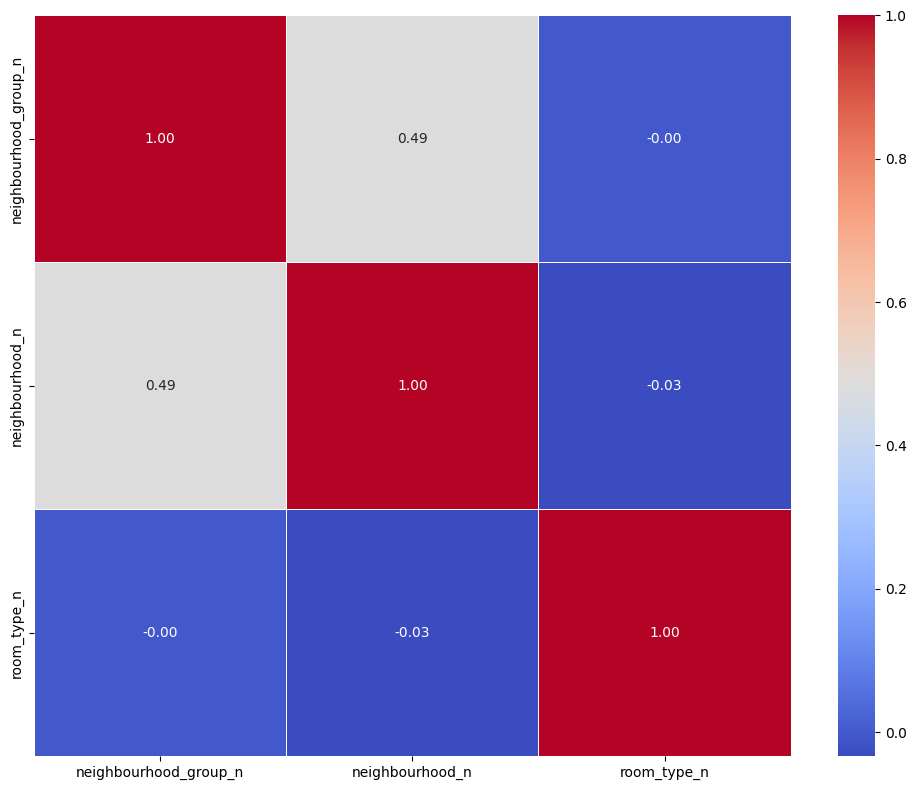

In [31]:
    
corr_matrix = data[categorical_variable_list].corr()
plt.figure(figsize=(10, 8))  
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

plt.tight_layout()

plt.show()

El análisis de correlaciones categóricas refleja una fuerte relación directa entre el distrito (`neighbourhood_group`) y el vecindario (`neighbourhood_n`). El resto de las correlaciones categóricas son débiles y no son tan significativas como para contemplarlas en el análisis.

Finalmente, para cerrar el estudio multivariante queda analizar la relación entre las variables categóricas y numéricas.

#### Análisis numérico-categórico (completo)

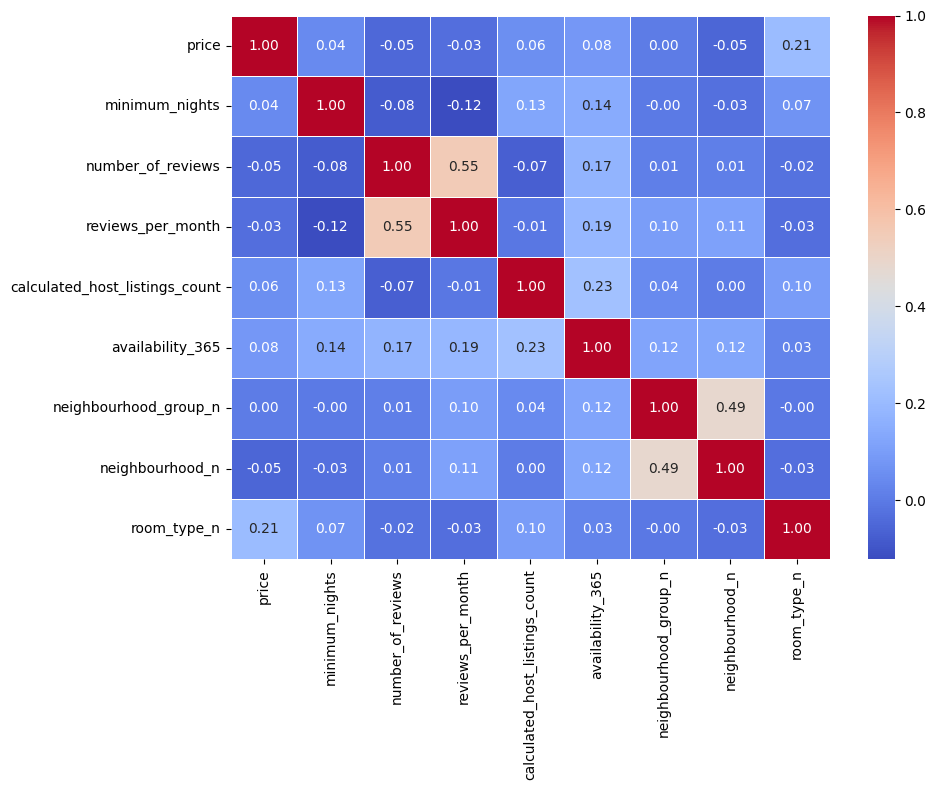

In [32]:
corr_matrix = data.select_dtypes(include=['number']).corr()

plt.figure(figsize=(10, 8))  
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

plt.tight_layout()

plt.show()

El análisis de correlaciones refleja una fuerte relación directa entre el tipo de habitación (`room_type`) de la reserva y su precio (`price`). Además, se aprecia una relación entre el número de de días disponibles (`availability_365`) que se encuentra el alquiler de el número de noches (`minimum_nights`), número de reseñas(`number_of_reviews`), reseñas por mes (`reviews_per_month`) y cuantas propiedades tiene el host listadas (`calculated_host_listings_count`). El resto de las correlaciones son débiles y no son tan significativas como para contemplarlas en el análisis. Como se ha mencionado en en análisis de correlaciones categórica-categórica las variables `neighbourhood_n` y `neighbourhood_group_n` presentan una correlación moderada.

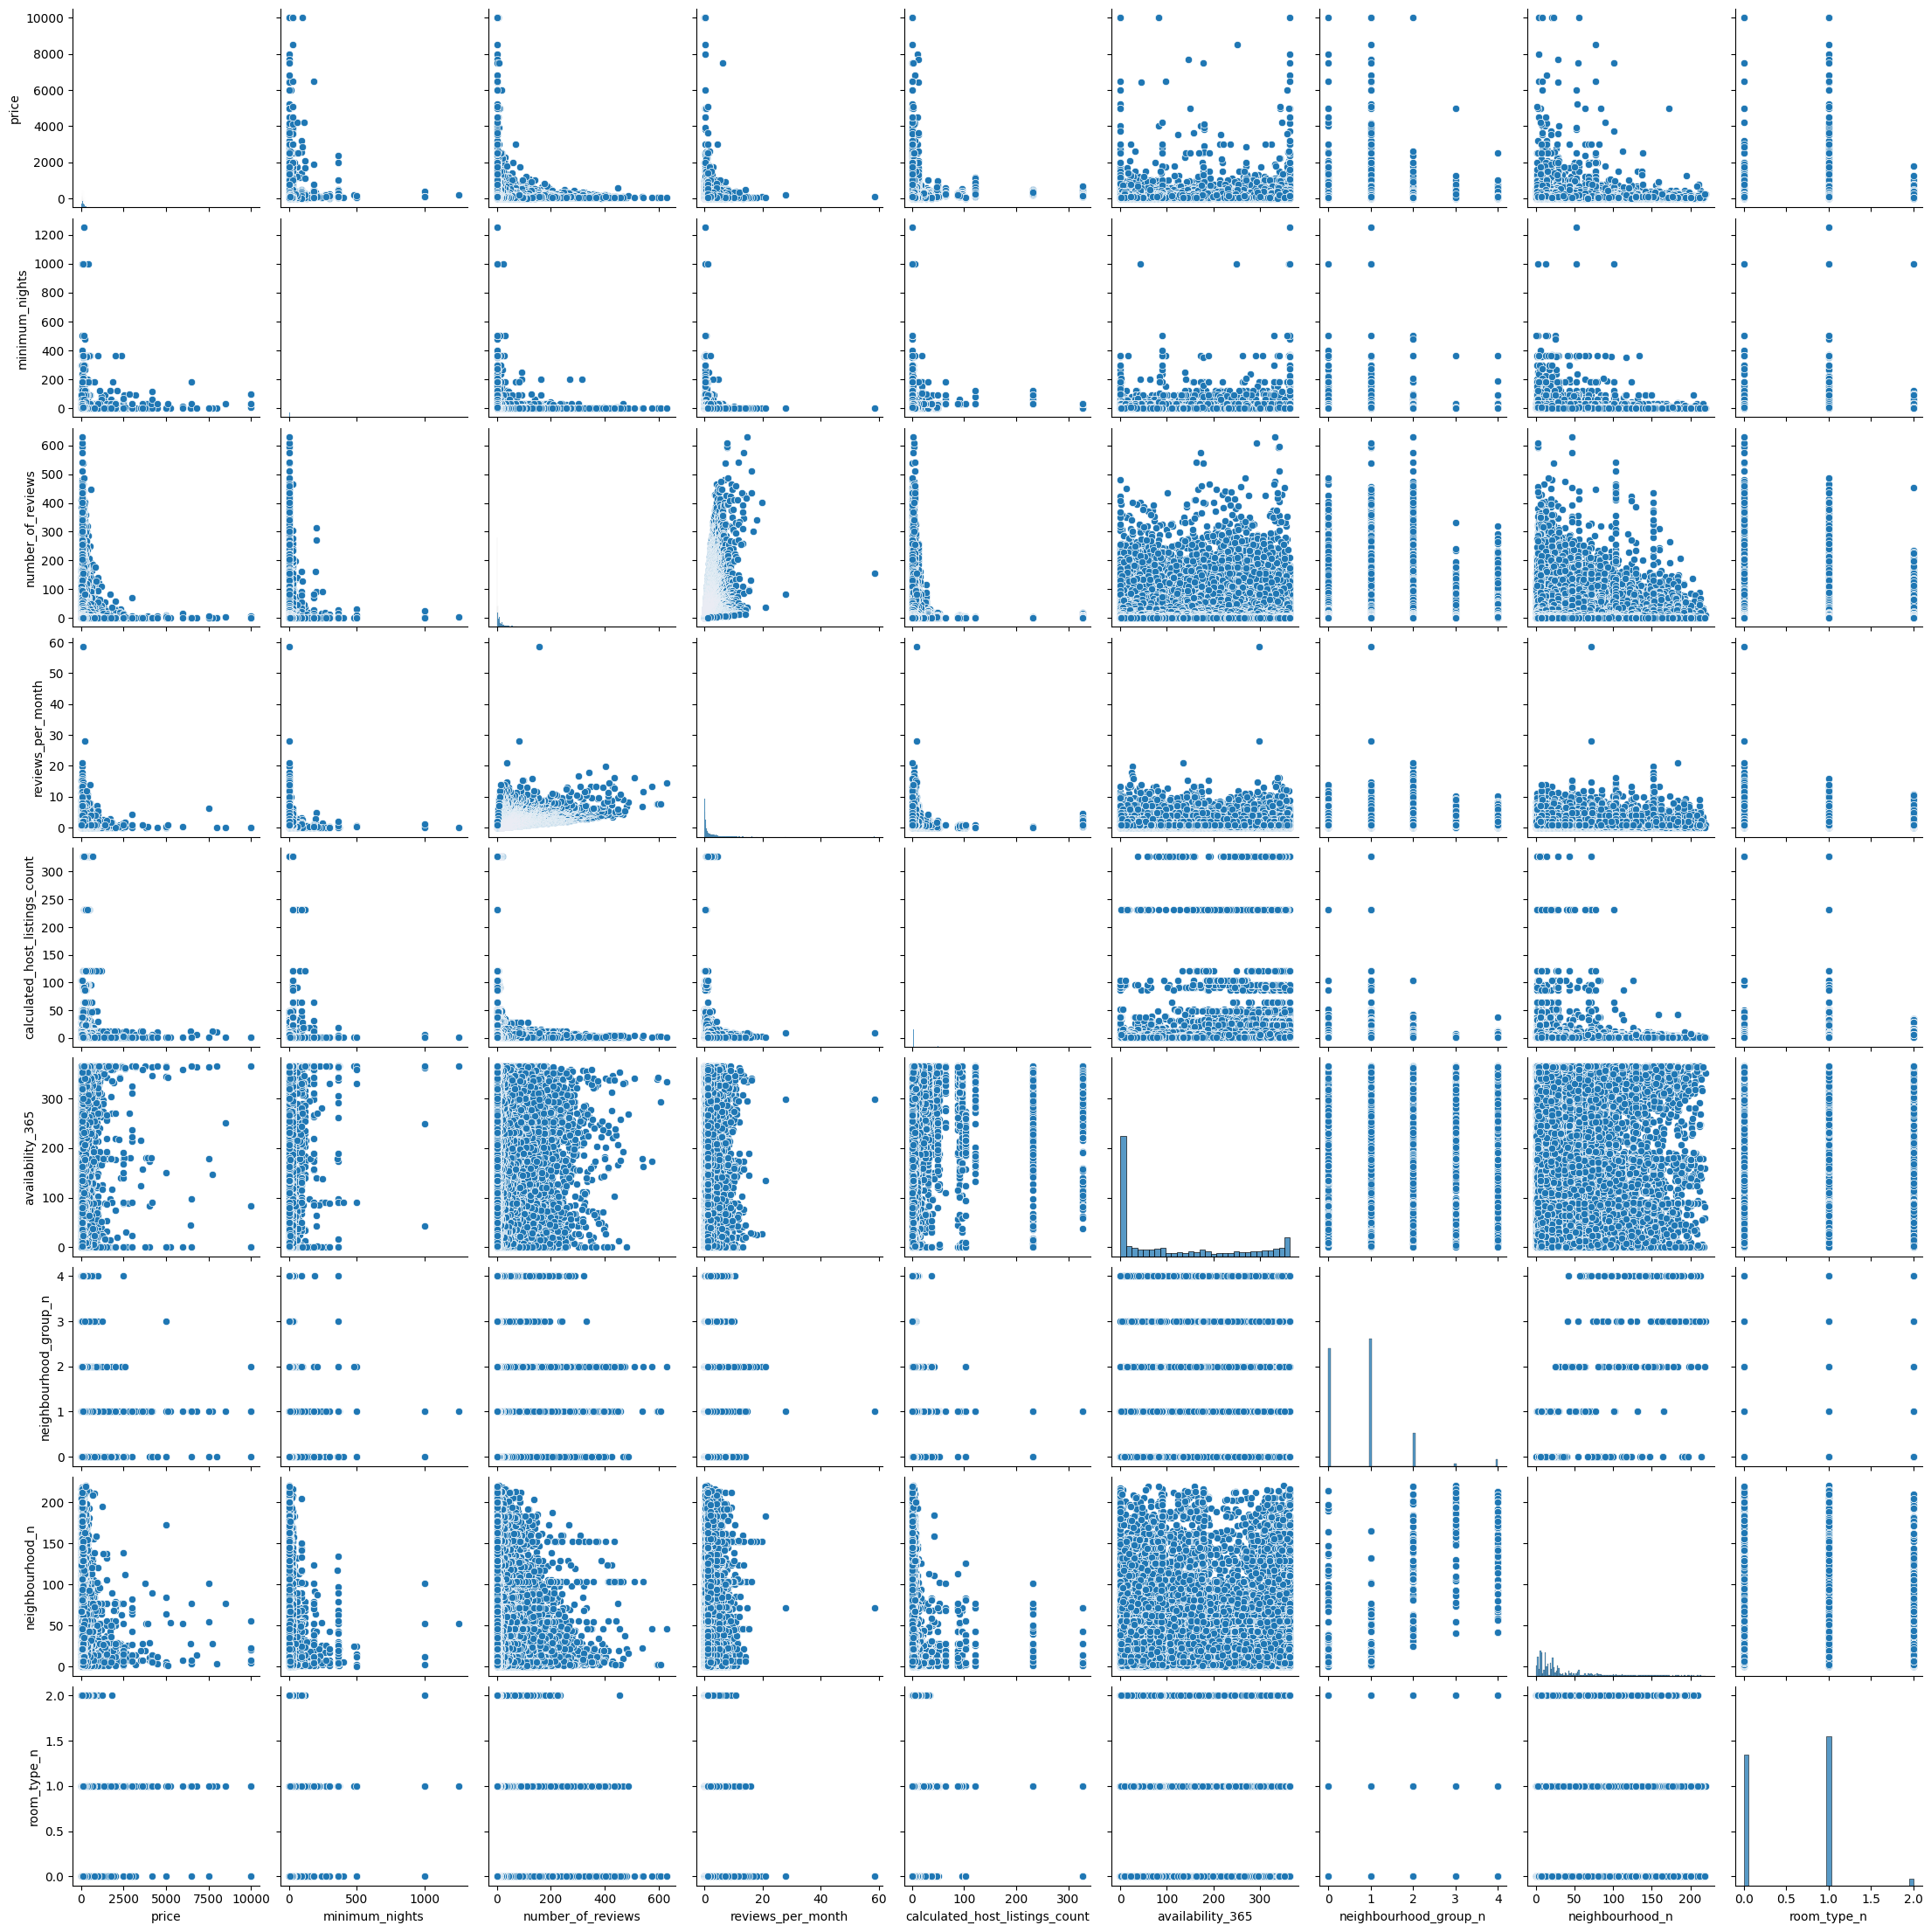

In [33]:
sns.pairplot(data = data)

### Paso 5: Ingeniería de características

#### Análisis de outliers

In [34]:
data.describe()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_n,neighbourhood_n,room_type_n
count,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327,0.786911,29.888782,0.567113
std,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289,0.844386,34.676634,0.541249
min,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000,0.000000,7.500000,0.000000
50%,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000,1.000000,19.000000,1.000000
75%,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000,1.000000,37.000000,1.000000
max,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000,4.000000,220.000000,2.000000


In [35]:
columns_number = data.select_dtypes(include='number')

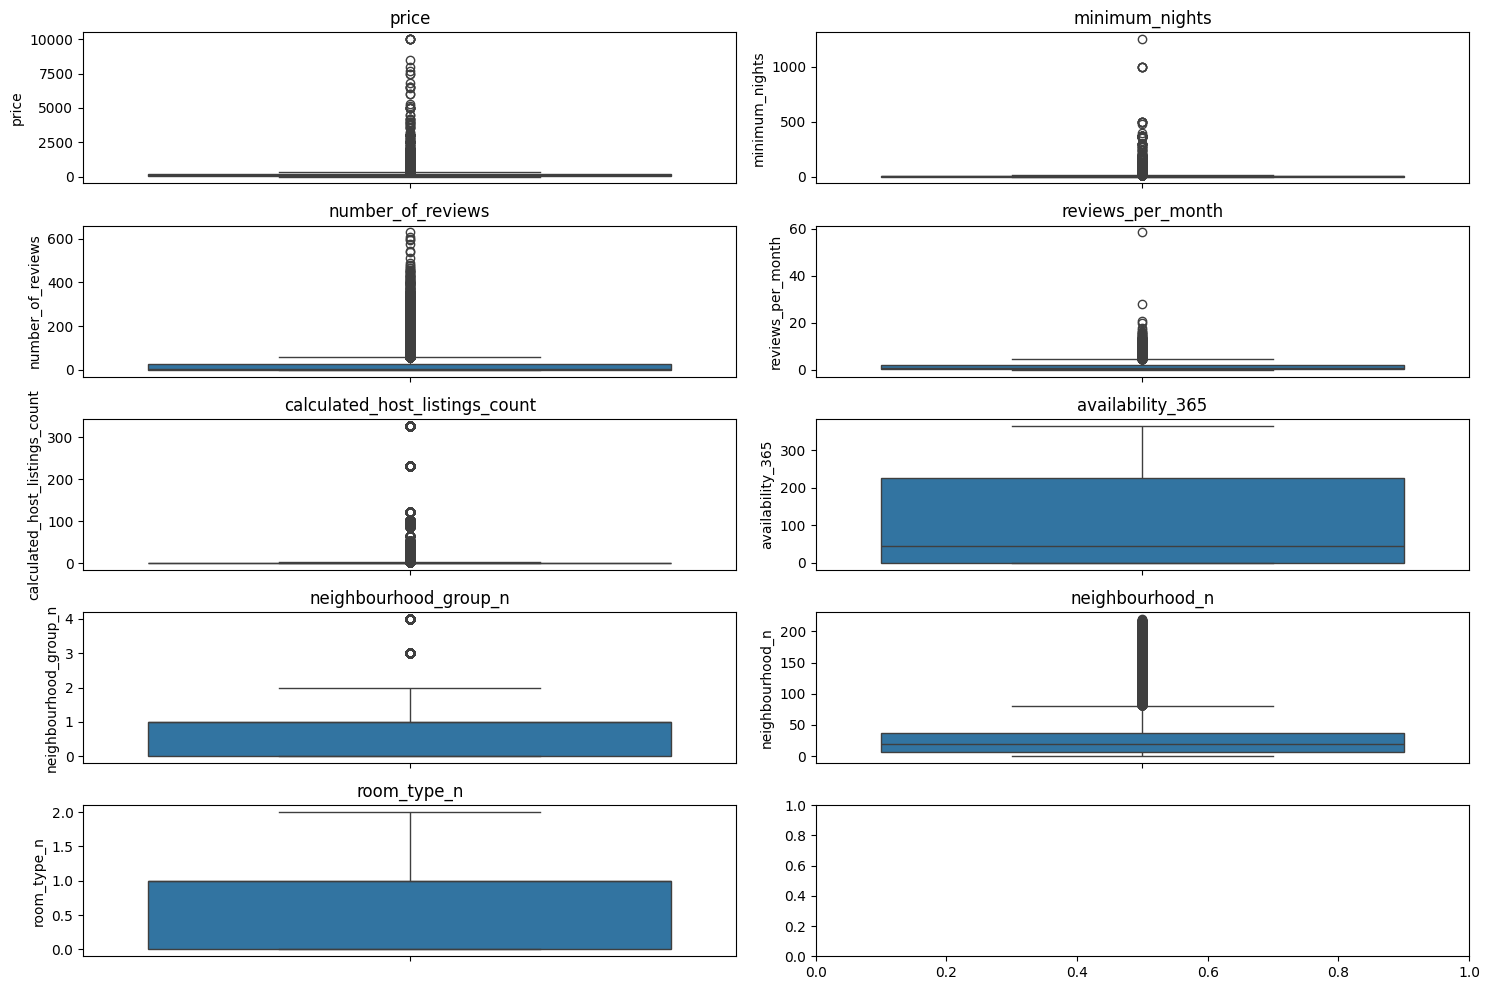

In [36]:
# Separar los gráficos en impares y pares
columns_odd = [col for i, col in enumerate(columns_number) if i % 2 != 0]  # Gráficos con índice impar (1, 3, 5,...)
columns_even = [col for i, col in enumerate(columns_number) if i % 2 == 0]  # Gráficos con índice par (0, 2, 4,...)

# Número de filas necesarias (igual a la cantidad máxima de gráficos en ambos grupos)
num_rows = max(len(columns_odd), len(columns_even))

# Crear la figura y los subgráficos
fig, axis = plt.subplots(num_rows, 2, figsize=(15, 10))

# Graficar los gráficos impares (a la izquierda)
for i, col in enumerate(columns_even):
    sns.boxplot(ax=axis[i, 0], data=data, y=col)
    axis[i, 0].set_title(col)

# Graficar los gráficos pares (a la derecha)
for i, col in enumerate(columns_odd):
    sns.boxplot(ax=axis[i, 1], data=data, y=col)
    axis[i, 1].set_title(col)

# sns.boxplot(ax = axis[0, 1], data = data, y = "minimum_nights")
# sns.boxplot(ax = axis[0, 2], data = data, y = "number_of_reviews")
# sns.boxplot(ax = axis[1, 0], data = data, y = "reviews_per_month")
# sns.boxplot(ax = axis[1, 1], data = data, y = "calculated_host_listings_count")
# sns.boxplot(ax = axis[1, 2], data = data, y = "availability_365")
# sns.boxplot(ax = axis[2, 0], data = data, y = "neighbourhood_group_n")
# sns.boxplot(ax = axis[2, 1], data = data, y = "room_type_n")
# sns.boxplot(ax = axis[2, 2], data = data, y = "neighbourhood_n")

plt.tight_layout()

plt.show()

In [37]:
data.select_dtypes(include='number').columns

Index(['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'neighbourhood_group_n', 'neighbourhood_n', 'room_type_n'],
      dtype='object')

In [38]:
import json

total_data_con_outliers = data.copy()
total_data_sin_outliers = data.copy()
def convert_to_standard_types(obj):
  if isinstance(obj, np.int64):  # Convertir numpy.int64 a int
      return int(obj)
  elif isinstance(obj, np.float64):  # Convertir numpy.float64 a float
      return float(obj)
  
def replace_outliers_from_column(column, df):
  column_stats = df[column].describe()
  
  column_iqr = column_stats["75%"] - column_stats["25%"]
  # print("Column IQR:",column_iqr)
  # print("25%:",column_stats["25%"])
  upper_limit = column_stats["75%"] + 1.5 * column_iqr
  lower_limit = column_stats["25%"] - 1.5 * column_iqr
  lower_limit = max(df[column].min(),lower_limit)
  print(lower_limit)
  
  # Remove upper outliers
  df[column] = df[column].apply(lambda x: x if (x <= upper_limit) else upper_limit)
  # Remove lower outliers
  df[column] = df[column].apply(lambda x: x if (x >= lower_limit) else lower_limit)
  
  return df.copy(), [lower_limit, upper_limit]
def replace_outliers_from_column_with_clip(column, df):
  column_stats = df[column].describe()
  
  column_iqr = column_stats["75%"] - column_stats["25%"]
  # print("Column IQR:",column_iqr)
  # print("25%:",column_stats["25%"])
  upper_limit = column_stats["75%"] + 1.5 * column_iqr
  lower_limit = column_stats["25%"] - 1.5 * column_iqr
  lower_limit = max(df[column].min(),lower_limit)
  # print(lower_limit)
  
  # Remove upper outliers
  df[column] = df[column].clip(lower=lower_limit, upper=upper_limit)
  
  
  return df.copy(), [lower_limit, upper_limit]
outliers_dict = {}
for column in columns_number:
  total_data_sin_outliers, limits_list = replace_outliers_from_column_with_clip(column, total_data_sin_outliers)
  outliers_dict[column] = limits_list

outliers_dict_standard = convert_to_standard_types(outliers_dict)

with open("outliers_replacement.json", "w") as f:
  json.dump(outliers_dict_standard, f)
outliers_dict

{'price': [np.int64(0), np.float64(334.0)],
 'minimum_nights': [np.int64(1), np.float64(11.0)],
 'number_of_reviews': [np.int64(0), np.float64(58.5)],
 'reviews_per_month': [np.float64(0.01), np.float64(4.765000000000001)],
 'calculated_host_listings_count': [np.int64(1), np.float64(3.5)],
 'availability_365': [np.int64(0), np.float64(567.5)],
 'neighbourhood_group_n': [np.int64(0), np.float64(2.5)],
 'neighbourhood_n': [np.int64(0), np.float64(81.25)],
 'room_type_n': [np.int64(0), np.float64(2.5)]}

In [39]:
total_data_con_outliers.isnull().sum().sort_values(ascending=False)

reviews_per_month                 10052
neighbourhood_group                   0
room_type                             0
neighbourhood                         0
price                                 0
minimum_nights                        0
number_of_reviews                     0
calculated_host_listings_count        0
availability_365                      0
neighbourhood_group_n                 0
neighbourhood_n                       0
room_type_n                           0
dtype: int64

In [40]:
columns_na_con_outliers = total_data_con_outliers.loc[:,total_data_con_outliers.isnull().any()].columns



In [41]:
total_data_sin_outliers.isnull().sum().sort_values(ascending=False)

reviews_per_month                 10052
neighbourhood_group                   0
room_type                             0
neighbourhood                         0
price                                 0
minimum_nights                        0
number_of_reviews                     0
calculated_host_listings_count        0
availability_365                      0
neighbourhood_group_n                 0
neighbourhood_n                       0
room_type_n                           0
dtype: int64

In [42]:
columns_na_sin_outliers = total_data_sin_outliers.loc[:,total_data_sin_outliers.isnull().any()].columns

In [43]:
def replace_na_with_mean(columns_na_outliers, total_data, con_outliers="con"):
    total_data = total_data.copy()
    for na_outlier in columns_na_outliers:
        if na_outlier in total_data.columns:    # si la columna no está en el DF
            total_data[na_outlier] = total_data[na_outlier].fillna(
                total_data[na_outlier].mean()
            )
        else:
            print("La columna no se encuentra en el DataFrame: Revisa que tiene los nombres correctos")
    print(f"Se han rellenado los NAs en total_data_{con_outliers}_outliers")
    return total_data

if(not columns_na_con_outliers.empty):
    total_data_con_outliers = replace_na_with_mean(columns_na_con_outliers,total_data=total_data_con_outliers)
if(not columns_na_sin_outliers.empty):    
    total_data_sin_outliers = replace_na_with_mean(columns_na_sin_outliers, total_data=total_data_sin_outliers,con_outliers="sin")

Se han rellenado los NAs en total_data_con_outliers
Se han rellenado los NAs en total_data_sin_outliers


In [44]:
total_data_con_outliers.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
neighbourhood_group_n             0
neighbourhood_n                   0
room_type_n                       0
dtype: int64

In [45]:
total_data_sin_outliers.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
neighbourhood_group_n             0
neighbourhood_n                   0
room_type_n                       0
dtype: int64

Vemos cómo los valores han sido imputados correctamente y ya no existen faltantes.

#### Inferencia de nuevas características

Otro uso típico en esta ingeniería es la de la obtención de nuevas características mediante la "fusión" de dos o más ya existentes. Uniendo estas dos variables y sumándolas/multiplicando/operación matemática/etc podemos obtener una tercera. En nuestro caso no lo hacemos ya que son variables que no se podría hacer dicha fusión. 

`¿Sería posible concatenar los números de aquellas categóricas? En principio si¿Habría que hacerlo en aquellas con una alta correlación entre sí? No tiene nada que ver con la correlación ¿se mantendrían el resto de variables de antes de la fusión? No se mantendrían`

In [46]:
total_data_con_outliers["neighbourhood_n"].sort_values(ascending=False)

34161    220
33698    219
34429    219
48751    219
33261    218
        ... 
1465       0
6153       0
41569      0
0          0
42310      0
Name: neighbourhood_n, Length: 48895, dtype: int64

In [47]:
# DEFINIR LA INFERENCIA DE LA NUEVA CARACTERÍSTICA [NECESARIO FACTOR HUMANO - OPCIONAL]]
exclude_new_features = ["neighbourhood_group_n","neighbourhood_n"]
# Sin outliers 
total_data_sin_outliers['neighbourhood_group_n'] = total_data_sin_outliers['neighbourhood_group_n'].astype(int)
total_data_sin_outliers['neighbourhood_n'] = total_data_sin_outliers['neighbourhood_n'].astype(int)
# Con outliers 
total_data_con_outliers['neighbourhood_group_n'] = total_data_con_outliers['neighbourhood_group_n'].astype(int)
total_data_con_outliers['neighbourhood_n'] = total_data_con_outliers['neighbourhood_n'].astype(int)
# Inferencia de nuevas características
total_data_sin_outliers['neighbourhood'] = total_data_sin_outliers.apply(lambda row: 1000*row['neighbourhood_group_n'] + row['neighbourhood_n'], axis=1)
total_data_con_outliers['neighbourhood'] = total_data_con_outliers.apply(lambda row: 1000*row['neighbourhood_group_n'] + row['neighbourhood_n'], axis=1)



#### Escalado de valores

In [48]:
from sklearn.model_selection import train_test_split

num_variables = total_data_con_outliers.select_dtypes(include='number').drop(columns=[target] + exclude_new_features).columns.to_list()

# Dividimos el conjunto de datos en muestras de train y test
X_con_outliers = total_data_con_outliers.drop(columns=target, axis = 1)[num_variables]
X_sin_outliers = total_data_sin_outliers.drop(columns=target, axis = 1)[num_variables]
y = total_data_con_outliers[target]

X_train_con_outliers, X_test_con_outliers, y_train, y_test = train_test_split(X_con_outliers, y, test_size = 0.2, random_state = 42)
X_train_sin_outliers, X_test_sin_outliers = train_test_split(X_sin_outliers, test_size = 0.2, random_state = 42)



# GUARDAR LOS DATASETS
X_train_con_outliers.to_excel(os.path.join(current_dir,"../data/processed/X_train_con_outliers.xlsx"), index = False)
X_train_sin_outliers.to_excel(os.path.join(current_dir,"../data/processed/X_train_sin_outliers.xlsx"), index = False)
X_test_con_outliers.to_excel(os.path.join(current_dir,"../data/processed/X_test_con_outliers.xlsx"), index = False)
X_test_sin_outliers.to_excel(os.path.join(current_dir,"../data/processed/X_test_sin_outliers.xlsx"), index = False)
y_train.to_excel(os.path.join(current_dir,"../data/processed/y_train.xlsx"), index = False)
y_test.to_excel(os.path.join(current_dir,"../data/processed/y_test.xlsx"), index = False)

X_train_con_outliers.head()

,neighbourhood,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,room_type_n
32645,12,3,11,0.870000,1,1,1
23615,1030,2,2,0.160000,1,0,0
31183,6,2,0,1.373221,2,0,0
29260,6,3,87,4.910000,1,267,1
7275,2031,5,13,0.250000,1,0,0


#### Normalización Funciones

In [49]:
from sklearn.preprocessing import StandardScaler
print(type(X_train_con_outliers),type(X_test_con_outliers))
def normalize_dataframe_and_save(type_scaler, X_train, X_test, num_variables, scaler="Standard", con_outliers = "con"):
    ### NORMALIZAMOS EL DATAFRAME CON OUTLIERS Y LO GUARDAMOS
    #scaler_con_outliers = StandardScaler()
    type_scaler.fit(X_train)

    X_train_norm = type_scaler.transform(X_train)
    X_train_norm = pd.DataFrame(X_train_norm, index = X_train.index, columns = num_variables)

    X_test_norm = type_scaler.transform(X_test)
    X_test_norm = pd.DataFrame(X_test_norm, index = X_test.index, columns = num_variables)

    # GUARDAR LOS DATASETS
    if((scaler.lower() == "standard") | (scaler.lower() == "minmax")):
        X_train_norm.to_excel(os.path.join(current_dir,f"../data/processed/X_train_{con_outliers}_outliers_norm_{scaler.lower()}.xlsx"), index = False)
        X_test_norm.to_excel(os.path.join(current_dir,f"../data/processed/X_test_{con_outliers}_outliers_norm_{scaler.lower()}.xlsx"), index = False)
    else:
        print("Error al indicar el escalado")
    return X_train_norm.copy(), X_test_norm.copy()

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


##### Normalización

Escalado Con Outliers

In [50]:
type_scaler = StandardScaler()
# Normalización Estándar Con Outliers
print(type(type_scaler))
X_train_con_outliers_norm_standard, X_test_con_outliers_norm_standard = normalize_dataframe_and_save(
    type_scaler=type_scaler, 
    X_train = X_train_con_outliers, 
    X_test = X_test_con_outliers, 
    num_variables = num_variables, 
    scaler="Standard",
    con_outliers = "con")
X_train_con_outliers_norm_standard.head()
# Normalización Estándar Sin Outliers
X_train_sin_outliers_norm_standard, X_test_sin_outliers_norm_standard = normalize_dataframe_and_save(
    type_scaler=type_scaler, 
    X_train = X_train_sin_outliers, 
    X_test = X_test_sin_outliers, 
    num_variables = num_variables, 
    scaler="Standard",
    con_outliers = "sin")
# Print Xtrain con Outliers normalizado
X_train_sin_outliers_norm_standard.head()

<class 'sklearn.preprocessing._data.StandardScaler'>


,neighbourhood,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,room_type_n
32645,-1.058763,-0.251775,-0.231781,-0.347167,-0.649717,-0.852862,0.798949
23615,0.384015,-0.552471,-0.673438,-0.917160,-0.649717,-0.860447,-1.050482
31183,-1.067266,-0.552471,-0.771584,-0.004154,0.406112,-0.860447,-1.050482
29260,-1.067266,-0.251775,2.099188,2.779767,-0.649717,1.164663,0.798949
7275,1.802700,0.349619,-0.133635,-0.844907,-0.649717,-0.860447,-1.050482


In [51]:
## APUNTES
# from sklearn.preprocessing import StandardScaler

# ### NORMALIZAMOS EL DATAFRAME CON OUTLIERS Y LO GUARDAMOS
# scaler_con_outliers = StandardScaler()
# scaler_con_outliers.fit(X_train_con_outliers)

# X_train_con_outliers_norm = scaler_con_outliers.transform(X_train_con_outliers)
# X_train_con_outliers_norm = pd.DataFrame(X_train_con_outliers_norm, index = X_train_con_outliers.index, columns = num_variables)

# X_test_con_outliers_norm = scaler_con_outliers.transform(X_test_con_outliers)
# X_test_con_outliers_norm = pd.DataFrame(X_test_con_outliers_norm, index = X_test_con_outliers.index, columns = num_variables)

# # GUARDAR LOS DATASETS
# X_train_con_outliers_norm.to_excel("../data/processed/X_train_con_outliers_norm.xlsx", index = False)
# X_test_con_outliers_norm.to_excel("../data/processed/X_test_con_outliers_norm.xlsx", index = False)

# ### NORMALIZAMOS EL DATAFRAME SIN OUTLIERS Y LO GUARDAMOS
# scaler_sin_outliers = StandardScaler()
# scaler_sin_outliers.fit(X_train_sin_outliers)

# X_train_sin_outliers_norm = scaler_sin_outliers.transform(X_train_sin_outliers)
# X_train_sin_outliers_norm = pd.DataFrame(X_train_sin_outliers_norm, index = X_train_sin_outliers.index, columns = num_variables)

# X_test_sin_outliers_norm = scaler_sin_outliers.transform(X_test_sin_outliers)
# X_test_sin_outliers_norm = pd.DataFrame(X_test_sin_outliers_norm, index = X_test_sin_outliers.index, columns = num_variables)

# # GUARDAR LOS DATASETS
# X_train_sin_outliers_norm.to_excel("../data/processed/X_train_sin_outliers_norm.xlsx", index = False)
# X_test_sin_outliers_norm.to_excel("../data/processed/X_test_sin_outliers_norm.xlsx", index = False)

# X_train_con_outliers_norm.head()

##### Escalado Mínimo-Máximo

In [52]:
from sklearn.preprocessing import MinMaxScaler
type_scaler = MinMaxScaler()
print(type(type_scaler))
# Escalado Min-Max con outliers - Acotado entre 0-1
X_train_con_outliers_norm_minmax, X_test_con_outliers_norm_minmax = normalize_dataframe_and_save(
    type_scaler = type_scaler, 
    X_train = X_train_con_outliers, 
    X_test = X_test_con_outliers, 
    num_variables = num_variables, 
    scaler="MinMax",
    con_outliers = "con")
# Escalado Min-Max sin outliers - Acotado entre 0-1
X_train_sin_outliers_norm_minmax, X_test_sin_outliers_norm_minmax = normalize_dataframe_and_save(
    type_scaler = type_scaler, 
    X_train = X_train_sin_outliers, 
    X_test = X_test_sin_outliers, 
    num_variables = num_variables, 
    scaler="MinMax",
    con_outliers = "sin")
# Print data
X_train_sin_outliers_norm_minmax.head()

<class 'sklearn.preprocessing._data.MinMaxScaler'>


,neighbourhood,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,room_type_n
32645,0.005766,0.2,0.188034,0.180862,0.0,0.002740,0.5
23615,0.494954,0.1,0.034188,0.031546,0.0,0.000000,0.0
31183,0.002883,0.1,0.000000,0.270718,0.4,0.000000,0.0
29260,0.002883,0.2,1.000000,1.000000,0.0,0.731507,0.5
7275,0.975973,0.4,0.222222,0.050473,0.0,0.000000,0.0


In [53]:
## APUNTES
# from sklearn.preprocessing import MinMaxScaler

# ### NORMALIZAMOS EL DATAFRAME CON OUTLIERS Y LO GUARDAMOS
# scaler_con_outliers = MinMaxScaler()
# scaler_con_outliers.fit(X_train_con_outliers)

# X_train_con_outliers_scal = scaler_con_outliers.transform(X_train_con_outliers)
# X_train_con_outliers_scal = pd.DataFrame(X_train_con_outliers_scal, index = X_train_con_outliers.index, columns = num_variables)

# X_test_con_outliers_scal = scaler_con_outliers.transform(X_test_con_outliers)
# X_test_con_outliers_scal = pd.DataFrame(X_test_con_outliers_scal, index = X_test_con_outliers.index, columns = num_variables)

# # GUARDAR LOS DATASETS
# X_train_con_outliers_scal.to_excel("../data/processed/X_train_con_outliers_scal.xlsx", index = False)
# X_test_con_outliers_scal.to_excel("../data/processed/X_test_con_outliers_scal.xlsx", index = False)

# ### ESCALAMOS EL DATAFRAME SIN OUTLIERS Y LO GUARDAMOS
# scaler_sin_outliers = StandardScaler()
# scaler_sin_outliers.fit(X_train_sin_outliers)

# X_train_sin_outliers_scal = scaler_sin_outliers.transform(X_train_sin_outliers)
# X_train_sin_outliers_scal = pd.DataFrame(X_train_sin_outliers_scal, index = X_train_sin_outliers.index, columns = num_variables)

# X_test_sin_outliers_scal = scaler_sin_outliers.transform(X_test_sin_outliers)
# X_test_sin_outliers_scal = pd.DataFrame(X_test_sin_outliers_scal, index = X_test_sin_outliers.index, columns = num_variables)

# # GUARDAR LOS DATASETS
# X_train_sin_outliers_scal.to_excel("../data/processed/X_train_sin_outliers_scal.xlsx", index = False)
# X_test_sin_outliers_scal.to_excel("../data/processed/X_test_sin_outliers_scal.xlsx", index = False)

# X_train_con_outliers_scal.head()

## DÍA 3

### Paso 6: Selección de características

La **selección de características** (*feature selection*) es un proceso que implica seleccionar las características (variables) más relevantes de nuestro conjunto de datos para usarlas en la construcción de un modelo de Machine Learning, desechando el resto.

Existen varias razones para incluirlo en nuestro análisis exploratorio:

1. Simplificar el modelo para que sea más fácil de entender e interpretar.
2. Reducir el tiempo de entrenamiento del modelo.
3. Evitar el sobre ajuste al reducir la dimensionalidad del modelo y minimizar el ruido y las correlaciones innecesarias.
4. Mejorar el rendimiento del modelo al eliminar las características irrelevantes.

Además, existen diversas técnicas para la selección de características. Muchas de ellas se basan a su vez en modelos supervisados, entrenados o de clustering, tienes más información [aquí](https://github.com/4GeeksAcademy/machine-learning-content/blob/master/05-data/feature-selection.es.md).

La librería `sklearn` contiene gran parte de las mejores alternativas para llevarla a cabo. Una de las herramientas que más se utilizan para realizar procesos de selección de características rápidos y con buenos resultados es `SelectKBest`. Esta función selecciona las `k` mejores características de nuestro conjunto de datos basándose en una función de un test estadístico. Este test estadístico normalmente es un ANOVA o un Chi-Cuadrado:

In [61]:
from sklearn.feature_selection import f_classif, SelectKBest
def select_characteristics(X_train_con_outliers,X_test_con_outliers, y_train, y_test, with_outliers="with_outliers", scaler="standard"):
  # Con un valor de k = 5 decimos implícitamente que queremos eliminar 2 características del conjunto de datos
  selection_model = SelectKBest(f_classif, k = 5)
  selection_model.fit(X_train_con_outliers, y_train)

  ix = selection_model.get_support()
  X_train_sel = pd.DataFrame(selection_model.transform(X_train_con_outliers), columns = X_train_con_outliers.columns.values[ix])
  X_test_sel = pd.DataFrame(selection_model.transform(X_test_con_outliers), columns = X_test_con_outliers.columns.values[ix])

  # GUARDO X_train_sel.columns

  # name_files = ["with_outliers_without_norm", "without_outliers_without_norm","with_outliers_with_norm", "without_outliers_with_norm"] # name files
  # for col in name_files:

  with open(f"feature_selection_k_5_{with_outliers}_{scaler}.json", "w") as f:
    json.dump(X_train_sel.columns.tolist(), f)
  # GUARDO EL "Y" EN EL DATAFRAME
  X_train_sel[target] = list(y_train)
  X_test_sel[target] = list(y_test)
  # GUARDAR EL ARCHIVO LIMPIO
  X_train_sel.to_csv(os.path.join(current_dir,f"../data/processed/assets/clean_airbnb_{with_outliers}_train_{scaler}.csv"), index=False)
  X_test_sel.to_csv(os.path.join(current_dir,f"../data/processed/assets/clean_airbnb_{with_outliers}_test_{scaler}.csv"), index=False)

  return X_train_sel, X_test_sel

In [ ]:
# Without Scaler
# X_train_sel_with_outliers_without_norm, X_test_sel_with_outliers_without_norm = select_characteristics(X_train_con_outliers,X_test_con_outliers, y_train, y_test, with_outliers="with_outliers", with_norm="without_norm", scaler="standard")
# X_train_sel_without_outliers_without_norm, X_test_sel_without_outliers_without_norm = select_characteristics(X_train_sin_outliers,X_test_sin_outliers, y_train, y_test, with_outliers="without_outliers", with_norm="without_norm", scaler="standard")
# Scaler Standard
X_train_sel_with_outliers_with_norm_standard, X_test_sel_with_outliers_with_norm_standard = select_characteristics(X_train_con_outliers_norm_standard,X_test_con_outliers_norm_standard, y_train, y_test, with_outliers="with_outliers", scaler="standard")
X_train_sel_without_outliers_with_norm_standard, X_test_sel_without_outliers_with_norm_standard = select_characteristics(X_train_sin_outliers_norm_standard,X_test_sin_outliers_norm_standard, y_train, y_test, with_outliers="without_outliers", scaler="standard")
X_test_sel_without_outliers_with_norm_standard.head()

In [65]:
# Scaler MinMax
X_train_sel_with_outliers_with_norm_minmax, X_test_sel_with_outliers_with_norm_minmax = select_characteristics(X_train_con_outliers_norm_minmax, X_test_con_outliers_norm_minmax, y_train, y_test, with_outliers="with_outliers",  scaler="minmax")
X_train_sel_without_outliers_with_norm_minmax, X_test_sel_without_outliers_with_norm_minmax = select_characteristics(X_train_sin_outliers_norm_minmax, X_test_sin_outliers_norm_minmax, y_train, y_test, with_outliers="without_outliers", scaler="minmax")
X_test_sel_without_outliers_with_norm_minmax.head()

,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,room_type_n,price
0,0.2,1.000000,0.0,0.517808,0.5,89
1,1.0,0.000000,0.0,0.200000,0.0,30
2,0.1,0.290598,0.0,0.000000,0.0,120
3,0.1,0.085470,1.0,0.745205,0.5,470
4,0.1,0.512821,0.0,0.082192,0.5,199


In [56]:
# X_train_sel_with_outliers_without_norm[target] = list(y_train)
# X_test_sel_with_outliers_without_norm[target] = list(y_test)

In [57]:
# X_train_sel_with_outliers_without_norm.to_csv("../data/processed/assets/clean_airbnb_with_outliers_without_norm_train.csv", index=False)
# X_test_sel_with_outliers_without_norm.to_csv("../data/processed/assets/clean_airbnb_with_outliers_without_norm_test.csv", index=False)


La selección de características, al igual que el entrenamiento del modelo en general, se debe realizar solo en el conjunto de datos de entrenamiento y no en la totalidad. Si la llevásemos a cabo en todo el conjunto, podríamos introducir un sesgo que se conoce como **contaminación de datos** (*data leakage*), que ocurre cuando la información del conjunto de prueba se utiliza para tomar decisiones durante el entrenamiento, lo que puede llevar a una estimación demasiado optimista del rendimiento del modelo.

Por eso, la mejor práctica es dividir los datos en dos conjuntos: de entrenamiento y de prueba antes de la selección de características, que se realizará solo con los datos de entrenamiento y que luego se aplicará a ambos. De esta manera, aseguramos que este proceso y el modelo están siendo validados de manera justa.

En este caso, utilizando la selección de características de Chi cuadrado, las características más importantes son `Pclass`, `Sex`, `Parch`, `Fare` y `Embarked`.

## FIN DEL DÍA 3

Ahora ya conocemos cómo llevar a cabo un estudio profundo y en detalle para conocer completamente nuestro conjunto de datos. Recordemos los pasos que tenemos que seguir para llevarlo a cabo:

- Paso 1: Planteamiento del problema y recopilación de datos
- Paso 2: Exploración y limpieza de datos
- Paso 3: Análisis de variables univariante
- Paso 4: Análisis de variables multivariante
- Paso 5: Ingeniería de características
- Paso 6: Selección de características

Tras la implementación y adopción de estos pasos, estaremos preparados para entrenar el modelo.